# Using Reddit's API for Classifying Subreddit Posts

This notebook regards the classification of geocaching and IWantToLearn subreddit posts from Reddit using Natural Language Processing techniques. For the workflow of obtaining the posts using webscraping techniques, please refer to the Jupyter Notebook "Project 3 Webscraping.ipynb". This project was segmented into two to prevent from re-running webscraping code.



Problem statement: What characteristics of a post on Reddit contribute most to what subreddit it belongs to?

### Library Imports

In [1]:
# Data cleaning/handling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
%matplotlib inline

# NLP specific libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import stop_words
import re
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer



# Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Bring in Dataset of Posts scraped from Reddit

In [2]:
df = pd.read_csv('./reddit_posts.csv')

In [3]:
df['subreddit'].value_counts()

IWantToLearn    1000
geocaching      1000
Name: subreddit, dtype: int64

We can see that there are an even 1000 posts scraped from Reddit from our Webscraping efforts.

## Text Cleaning Tools

In [3]:
# using regular expressions to remove punctuation in a function
def no_punct(string):
    return re.sub("[.,😯?😊!’\";^+`:*'()-@”“=>_$&<~%|{}\[\]]", " ", string)

In [4]:
# Create a function to clean any column or to feed into a word vectorizer as an analyzer parameter
def clean_func(column):
    
    #remove puntuation with punctuation removal function
    column = no_punct(column)
    
    #lowercase
    column = column.lower()
    
    return column

In [5]:
# Function that utilizes lemmatizing and a general Regex to remove punctuation

def preprocess(text):
    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # lowercase
    text = text.lower()
    
    # words only Regex, removes punctuation
    text = re.sub("[^A-Za-z]", " ", text)
    
    # lemmatize
    text = lemmatizer.lemmatize(text)
    
    return text

## Data cleaning and EDA

In [6]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
df.shape

(1995, 3)

In [8]:
df.describe().T

,count,unique,top,freq
text,1364,1364,"For a guy I'm rather emotional, I want to get ...",1
title,1995,1989,IWTL how to improve my logical thinking and pr...,2
subreddit,1995,2,geocaching,999


In [10]:
df.groupby('subreddit').describe().T

subreddit                                          IWantToLearn  \
text  count                                                 890   
      unique                                                890   
      top     I don't think I'm really particularly shy or a...   
      freq                                                    1   
title count                                                 996   
      unique                                                990   
      top                           I want to learn how to sing   
      freq                                                    2   

subreddit                                            geocaching  
text  count                                                 474  
      unique                                                474  
      top     I was going  for the World Turtle souvenir yes...  
      freq                                                    1  
title count                                                 999  
      unique                                                999  
      top                                 Trying to get started  
      freq                                                    1

#### Examining duplicate Titles

In [11]:
df['title'].value_counts().sort_values(ascending=False).head(10)

IWTL how to play the piano                                      2
IWTL how to improve my logical thinking and problem solving.    2
IWTL how to meditate                                            2
I want to learn to speak intellectually.                        2
I want to learn how to sing                                     2
IWTL how to sleep on my back                                    2
IWTL how to be honest without being a complete dick             1
Sneaky Decoy Camera Geocache!                                   1
What phone do you use?                                          1
IWTL estimating project cost and design fast.                   1
Name: title, dtype: int64

In [12]:
df[df['title']=='IWTL how to sleep on my back']

,text,title,subreddit
1220,My whole life I’ve been sleeping on my front a...,IWTL how to sleep on my back,IWantToLearn
1906,It is really difficult for me to fall asleep w...,IWTL how to sleep on my back,IWantToLearn


Not a duplicate, just a similar title.

In [13]:
df[df['title']=='IWTL how to play the piano']

,text,title,subreddit
1021,Any and all advice are welcome. (Iwtl easy ico...,IWTL how to play the piano,IWantToLearn
1212,So I've finally decided I'm going to make use ...,IWTL how to play the piano,IWantToLearn


Ok, text body is different.

In [14]:
df[df['title']=='I want to learn how to sing']

,text,title,subreddit
1573,I never had proper training on singing but I k...,I want to learn how to sing,IWantToLearn
1733,Long short story I can't afford a vocal coach....,I want to learn how to sing,IWantToLearn


Ok, text body is different.

In [15]:
df[df['title']=='IWTL how to meditate']

,text,title,subreddit
1284,I'm trying to learn to meditate but I'm not su...,IWTL how to meditate,IWantToLearn
1403,I want to try it out but I don't know where to...,IWTL how to meditate,IWantToLearn


Ok, text body is different.

In [16]:
df[df['title']=='I want to learn to speak intellectually.']

,text,title,subreddit
1009,I am awkwardly uncomfortable speaking out loud...,I want to learn to speak intellectually.,IWantToLearn
1979,I am awkwardly uncomfortable speaking out loud...,I want to learn to speak intellectually.,IWantToLearn


In [17]:
df['text'].iloc[1009]

'I am awkwardly uncomfortable speaking out loud about anything that I don’t know much about.  I constantly feel like my vocabulary is not where I want it to be.  I’m in college and I feel like I write like an 8th grader.  I say thinks like “like” and “dude” and “that’s what she said” a lot and I can’t seem to stop.  How do I change this?  Before you guys tell me to read more books, what exact books should I be reading?  Any other tips are welcomed.'

In [18]:
df['text'].iloc[1979]

'I am awkwardly uncomfortable speaking out loud about anything that I don’t know much about.  I constantly feel like my vocabulary is not where I want it to be.  I’m in college and I feel like I write like an 8th grader.  I say things like “like” and “dude” and “that’s what she said” a lot and I can’t seem to stop.  How do I change this?  Before you guys tell me to read more books, what exact books should I be reading?  Any other tips are welcomed.'

In [19]:
len(df['text'].iloc[1009])

451

In [20]:
len(df['text'].iloc[1979])

451

In [21]:
diff = []
for char in df['text'].iloc[1009]:
    if char not in df['text'].iloc[1979]:
        diff.append(char)
print(diff)

[]


These are duplicates even though I ran `.drop_duplicates` I can find no difference between the two posts so I will drop one arbitrarily anyway.

In [7]:
df.drop(1979, axis='index', inplace=True)

In [23]:
df[df['title']=='IWTL how to improve my logical thinking and problem solving.']

,text,title,subreddit
1002,"Hi guys, are there any good courses, games or ...",IWTL how to improve my logical thinking and pr...,IWantToLearn
1049,"Hi guys, are there any good courses, games or ...",IWTL how to improve my logical thinking and pr...,IWantToLearn


In [24]:
df['text'].iloc[1002]

'Hi guys, are there any good courses, games or exercises to improve my logical thinking and problem solving ?\nHow can i improve them ?\nThanks in Advance.'

In [25]:
df['text'].iloc[1049]

'Hi guys, are there any good courses, games or exercises ti improve mi logical thinking and problem solving ?\nHow can i improve them ?\nThanks in Advance.'

This is almost a verbatum text description but we can see that there were a few typos. What this means is that the redditor posted this thread and then edited it, but the Webscraper picked up both postings. In this case, drop the first post so as not to bias the models on the mytyped words and double count or weight the rest.

In [8]:
df.drop(1049, axis='index', inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
# Check to see that the two duplicates were removed.
df.shape

(1993, 3)

With the removal of duplicates, the new dataframe is 1993 posts long.

In [10]:
# Create boolean masks to examine geocaching and IWantToLearn subreddits separately.
geocaching = df['subreddit'] == 'geocaching'
iwtl = df['subreddit'] == 'IWantToLearn'

#### Examining null values

In [29]:
df.isnull().sum()

text         631
title          0
subreddit      0
dtype: int64

In [30]:
df[geocaching].isnull().sum()

text         525
title          0
subreddit      0
dtype: int64

In [31]:
df[iwtl].isnull().sum()

text         106
title          0
subreddit      0
dtype: int64

About half of the geocaching posts do not have text in the post description, while only 10% of IWantToLearn posts do not. What this could mean is that IWantToLearn redditors are more willing to go into detail in their posts while geocaching redditors do not or post links.

In [11]:
# Fill empty text posts with 'NA'
df.fillna('NA', inplace=True)

### Examining Title and Text by number of words in each

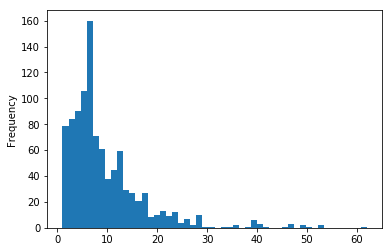

In [33]:
# Look at length of geocaching title
geo_title_length = df[geocaching]['title'].map(clean_func)
geo_title_length = geo_title_length.str.split()
geo_title_length = geo_title_length.apply(len)

# Plot as a histogram
geo_title_length.plot(bins=50, kind='hist');

In [34]:
geo_title_length.describe()

count    999.000000
mean       9.554555
std        8.033421
min        1.000000
25%        4.000000
50%        7.000000
75%       12.000000
max       62.000000
Name: title, dtype: float64

Mostly distributed under 10 words but really skewed with a long tail. So there are only a few outlier titles that are really long.

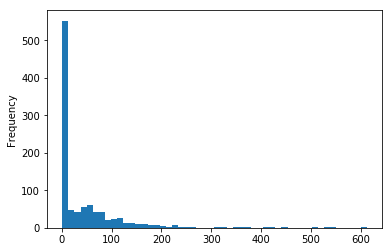

In [35]:
# Look at length of geocaching text
geo_text_length = df[geocaching]['text'].map(clean_func)
geo_text_length = geo_text_length.str.split()
geo_text_length = geo_text_length.apply(len)

geo_text_length.plot(bins=50, kind='hist');

Many posts have no text, or very short text bodies. But there is a much more longer skew with the tail on the right. Since text bodies can be longer, there are a few posts that are even longer than the longest titles

In [36]:
geo_text_length.describe()

count    999.000000
mean      41.844845
std       70.957119
min        1.000000
25%        1.000000
50%        1.000000
75%       61.000000
max      612.000000
Name: text, dtype: float64

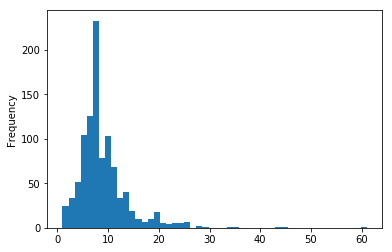

In [37]:
# Look at length of IWantToLearn title
iwtl_title_length = df[iwtl]['title'].map(clean_func)
iwtl_title_length = iwtl_title_length.str.split()
iwtl_title_length = iwtl_title_length.apply(len)

iwtl_title_length.plot(bins=50, kind='hist');

In [38]:
iwtl_title_length.describe()

count    994.000000
mean       8.823944
std        5.089154
min        1.000000
25%        6.000000
50%        8.000000
75%       10.000000
max       61.000000
Name: title, dtype: float64

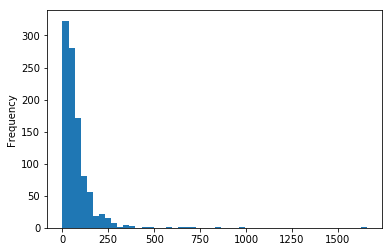

In [39]:
# Look at length of IWantToLearn text
iwtl_text_length = df[iwtl]['text'].map(clean_func)
iwtl_text_length = iwtl_text_length.str.split()
iwtl_text_length = iwtl_text_length.apply(len)

iwtl_text_length.plot(bins=50, kind='hist');

In [40]:
iwtl_text_length.describe()

count     994.000000
mean       75.691147
std        99.553647
min         1.000000
25%        27.000000
50%        54.000000
75%        92.000000
max      1657.000000
Name: text, dtype: float64

At a glance it looks like IWantToLearn titles and Geocaching titles are mostly distributed in less than 10 words. IWantToLearn posts have fewer "title only" type posts and tend to be longer than the geocaching posts that do have text.

## Creating Corpora

Keep title and post text separate before CountVector/TF-IDF and create models from each separately. Later, I will explore whether combining both title and post text make a significant difference.

In [12]:
title_corpus = df['title']
text_corpus = df['text']

#### Since I want to predict a binary variable - subreddit `0` for geocaching and `1` for IWantToLearn.

In [13]:
y = df['subreddit'].map({'geocaching': 0, 'IWantToLearn': 1})

## Natural Language Processing

#### Use `CountVectorizer` or `TfidfVectorizer` from scikit-learn to create features from the thread titles and descriptions (NOTE: Not all threads have a description)
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

### Master stopword list

In [14]:
# Create a master stopword list from both stopword lists
custom_stopwords = list(set(stopwords.words('english') + list(stop_words.ENGLISH_STOP_WORDS)))

# Add 'na' because it indicates an empty text post
custom_stopwords.extend(['na'])

In [44]:
len(custom_stopwords)

379

In [15]:
# Create a stopword list that only takes out 'na'
no_na = ['na']

## Count Vectorizer

In [46]:
# Instantiate countvectorizer, leave as default but make sure 'na' isnt a feature
cvec = CountVectorizer(stop_words=custom_stopwords)

In [47]:
title_counts = cvec.fit_transform(title_corpus)

In [48]:
counts = pd.DataFrame(title_counts.todense(), columns=cvec.vocabulary_)

In [49]:
counts.sum().sort_values(ascending=False)[0:20]

creative        747
including       181
letterboxing    158
gave            122
swearing        115
yay              94
named            67
concerning       63
area             61
rest             45
aggressive       42
robot            40
grade            37
prarie           36
teaming          35
elderly          35
webcam           34
puddles          34
logging          32
lisp             32
dtype: int64

In [50]:
text_counts = cvec.fit_transform(text_corpus)

In [51]:
counts2 = pd.DataFrame(text_counts.todense(), columns=cvec.vocabulary_)

In [52]:
counts2.sum().sort_values(ascending=False)[0:20]

dollar        686
energies      498
webpage       495
sounding      358
essex         356
rolled        341
opinion       340
quitting      303
holes         243
architect     229
topomap       225
ohvset        223
anyways       212
higher        209
analysing     207
62            201
slowest       192
unwilling     189
journaling    180
neo           178
dtype: int64

### Concatenate CountVectorized Title and Text. Use as a baseline to judge differences that TF-IDF makes.

In [53]:
all_counts = pd.concat([counts, counts2], axis=1)

In [54]:
all_counts.shape

(1993, 11746)

## TF-IDF

#### Does it make a difference?

In [55]:
# Instantiate 
tvec = TfidfVectorizer(stop_words=custom_stopwords)

In [56]:
title_tf = tvec.fit_transform(title_corpus)

In [57]:
title_tf_fit = pd.DataFrame(title_tf.todense(), columns=tvec.vocabulary_)

In [58]:
title_tf_fit.sum().sort_values(ascending=False)[0:20]

creative        126.094987
including        51.550776
letterboxing     43.527987
gave             36.557597
swearing         35.615514
yay              31.857491
named            21.233911
area             19.558801
concerning       18.284025
aggressive       16.920157
robot            15.453799
rest             15.144330
prarie           14.725293
elderly          14.506992
teaming          13.864109
puddles          13.387696
grade            13.277060
clearly          13.254618
logging          13.114324
webcam           12.088833
dtype: float64

In [59]:
text_tf = tvec.fit_transform(text_corpus)

In [60]:
text_tf_fit = pd.DataFrame(text_tf.todense(), columns=tvec.vocabulary_)

In [61]:
text_tf_fit.sum().sort_values(ascending=False)[0:20]

dollar       44.646933
webpage      39.627557
energies     38.361683
sounding     31.797101
opinion      27.367707
essex        26.799250
rolled       25.474496
holes        24.517034
quitting     23.847750
unwilling    23.007105
ohvset       22.063347
architect    20.525043
anyways      20.502431
topomap      20.176897
neo          19.434495
62           18.028269
higher       18.013527
spammy       17.272159
analysing    16.790722
slowest      16.442850
dtype: float64

### Test out different parameters for TF-IDF using GridSearchCV and the MultinomialNB

Commenting out after having run the following code to prevent it from running from an accidental "Run All" command and hanging all computer processing power.

### Title TF-IDF

In [255]:
# pipeline = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     ('model', MultinomialNB())
# ])

In [263]:
# params = {
#     'tvec__stop_words': [no_na, 'english', custom_stopwords],
#     'tvec__analyzer': ['word', preprocess],
#     'tvec__max_df': [500, 750, 1000],
#     'tvec__min_df': [1, 2, 3],
#     'tvec__ngram_range': [(1, 1), (1, 3)]
# }

In [264]:
# gs = GridSearchCV(pipeline, param_grid=params, cv=5)
# gs.fit(title_corpus, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...e,
        vocabulary=None)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tvec__stop_words': [['na'], 'english', ['take', 'our', 'nine', 'several', 'however', 'when', 'hereupon', 'eight', 'every', 'you', 'they', "didn't", 'may', 'even', 'beyond', 'perhaps', 'during', 'am', 'besides', 'top', 'of', 'was', 'a', 'thus', 'bottom', 'after', 'anyway', 'somewhere', "... 'tvec__max_df': [500, 750, 1000], 'tvec__min_df': [1, 2, 3], 'tvec__ngram_range': [(1, 1), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [265]:
# gs.best_score_

0.9644110275689223

Best score on titles: 0.965

In [266]:
# gs.best_params_

{'tvec__analyzer': 'word',
 'tvec__max_df': 750,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 3),
 'tvec__stop_words': ['na']}

Best parameters on titles:

`{'tvec__analyzer': 'word',
 'tvec__max_df': 750,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 3),
 'tvec__stop_words': ['na']}`

#### Best TF-IDF
Using these parameters, fit and transform the title corpus.

In [16]:
best_tvec = TfidfVectorizer(analyzer='word', max_df=750, min_df=1, ngram_range=(1,3), stop_words=no_na)

In [17]:
best_title_tf = best_tvec.fit_transform(title_corpus)

In [18]:
best_title_tf_fit = pd.DataFrame(best_title_tf.todense(), columns=best_tvec.vocabulary_)

### Text TF-IDF

In [255]:
# pipeline = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     ('model', MultinomialNB())
# ])

In [263]:
# params = {
#     'tvec__stop_words': [no_na, 'english', custom_stopwords],
#     'tvec__analyzer': ['word', preprocess],
#     'tvec__max_df': [500, 750, 1000],
#     'tvec__min_df': [1, 2, 3],
#     'tvec__ngram_range': [(1, 1), (1, 3)]
# }

In [267]:
# gs = GridSearchCV(pipeline, param_grid=params, cv=5)
# gs.fit(text_corpus, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...e,
        vocabulary=None)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tvec__stop_words': [['na'], 'english', ['take', 'our', 'nine', 'several', 'however', 'when', 'hereupon', 'eight', 'every', 'you', 'they', "didn't", 'may', 'even', 'beyond', 'perhaps', 'during', 'am', 'besides', 'top', 'of', 'was', 'a', 'thus', 'bottom', 'after', 'anyway', 'somewhere', "... 'tvec__max_df': [500, 750, 1000], 'tvec__min_df': [1, 2, 3], 'tvec__ngram_range': [(1, 1), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

In [268]:
# gs.best_score_

0.9218045112781955

Best score on text: 0.921

In [269]:
# gs.best_params_

{'tvec__analyzer': 'word',
 'tvec__max_df': 500,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': ['na']}

Best parameters on text:

`{'tvec__analyzer': 'word',
 'tvec__max_df': 500,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': ['na']}`
 
 By comparison between the two GridSearches, we see that though they differ in max_df, min_df, and ngram range both can agree on the use of the default `'word'` analyzer and the use of 'na' as the only stopword.

#### Best TF-IDF
Using these parameters, fit and transform the text corpus.

In [19]:
best_tvec = TfidfVectorizer(analyzer='word', max_df=500, ngram_range=(1,1), min_df= 3, stop_words=no_na)

In [20]:
best_text_tf = best_tvec.fit_transform(text_corpus)

In [21]:
best_text_tf_fit = pd.DataFrame(best_text_tf.todense(), columns=best_tvec.vocabulary_)

### Combine the vectorized Title and Text tables into one table of features

In [22]:
best_tf_corpus = pd.concat([best_title_tf_fit, best_text_tf_fit], axis=1)

## Train, Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(best_tf_corpus, y, test_size=0.3, random_state=42)

MemoryError: 

## Predicting subreddit using Random Forests + Another Classifier

#### The baseline accuracy for this model is the percentage of the majority class on the dataset.

In [36]:
df['subreddit'].value_counts(normalize=True)

geocaching      0.500752
IWantToLearn    0.499248
Name: subreddit, dtype: float64

#### Using a `RandomForestClassifier` model to predict which subreddit a given post belongs to.

In [ ]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

In [ ]:
cross_val_score(rf, X_train, y_train).mean()

In [ ]:
rf.fit(X_train, y_train);

In [ ]:
rf.score(X_test, y_test)

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 
- **Bonus**: Use `GridSearchCV` with `Pipeline` to optimize your `CountVectorizer`/`TfidfVectorizer` and classification model.

In [ ]:
pipeline = Pipeline([
    ('rf', RandomForestClassifier()), # Random Forest Classifier
    ('multi', MultinomialNB()), # MultinomialNB
    ('log_reg', LogisticRegression()), # Logistic Regression 
])

In [ ]:
params = {}

In [ ]:
gs = GridSearchCV(pipeline, param_grid=params, cv=5)
gs.fit()

#### Repeat the model-building process using a different classifier (e.g. `MultinomialNB`, `LogisticRegression`, etc)

In [ ]:
## YOUR CODE HERE

# Idea: Have separate branch where combine Title and Post Text then run count vectorizer / TF-IDF here

In [ ]:
corpus = df['title'] + ' ' + df['text']

# Executive Summary
---


Is there a difference in learning and outdoor exploration?

Both involve curiosity and wandering around in odd places, both on the internet and in the real world.